## **Оценка рисков ДТП по выбранному маршруту движения**

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Идея решения задачи от заказчика:**

- Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

**На основе модели исследовать основные факторы ДТП**
**Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:**
- Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
- Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 


## Подключитесь к базе. Загрузите таблицы sql

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None
from sklearn.metrics import recall_score
from catboost import CatBoostClassifier
import catboost
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
# загружаем базу данных
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
 

In [3]:
# создам подключение
engine = create_engine(connection_string) 

### Проведите первичное исследование таблиц

- Все ли таблицы имеют набор данных;
- Соответствует ли количество таблиц условию задачи;
- Имеется ли общий ключ для связи таблиц

In [4]:
query = '''
SELECT *
FROM parties
limit 10
'''

sample_parties = pd.read_sql_query(query, con=engine) 
sample_parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [5]:
query = '''
SELECT *
FROM vehicles
limit 10
'''

sample_vehicles = pd.read_sql_query(query, con=engine) 
sample_vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [6]:
query = '''
SELECT *
FROM collisions
limit 10
'''

sample_collisions = pd.read_sql_query(query, con=engine) 
sample_collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [7]:
query = '''
SELECT *
FROM collisions
limit 10
'''

sample_case_ids = pd.read_sql_query(query, con=engine) 
sample_case_ids.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


**ВЫВОД:**
- Все таблицы имеют набор данных;
- Количество таблиц соответствует условию задачи;
- Общий ключ для связи таблиц имеется (case_id)

##  Проведите статистический анализ факторов ДТП

In [8]:
# Выясним, в какие месяцы происходит наибольшее количество аварий
query = '''
select distinct extract(month from collision_date) month_date,
      count(case_id) total_collisions
from collisions
group by month_date
order by total_collisions desc
'''

count_collions = pd.read_sql_query(query, con=engine)
count_collions

,month_date,total_collisions
0,3.0,139581
1,1.0,132044
2,5.0,130316
3,4.0,130180
4,2.0,128858
5,10.0,112237
6,12.0,107945
7,9.0,105159
8,11.0,104770
9,8.0,104089


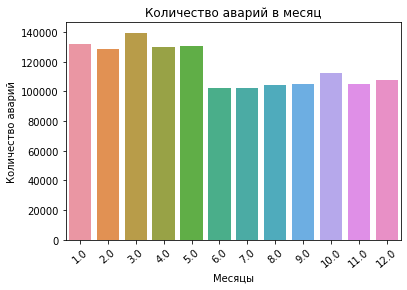

In [9]:
import seaborn as sns
sns.barplot(data = count_collions, x='month_date', y='total_collisions')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

<div class="alert alert-block alert-success"; style="border-left: 6px solid green">
<b>Успех ✔️</b>
       
Здорово, что не забываешь про оформление графиков!)
    
</div>


**ВЫВОД: Как очевидно из графика, наибольшее количество аварий приходится на март (139581), наименьшее количество аварий приходится на июль (102227).**

### **Проведем анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП:**

In [10]:
query = '''
select distinct road_surface,
       count(collision_damage) over (partition by road_surface) 
       count_collision_damage       
from collisions
'''
damage_collisions = pd.read_sql_query(query, con=engine)
damage_collisions

,road_surface,count_collision_damage
0,dry,1242026
1,wet,136236
2,None,13093
3,slippery,1384
4,snowy,7261


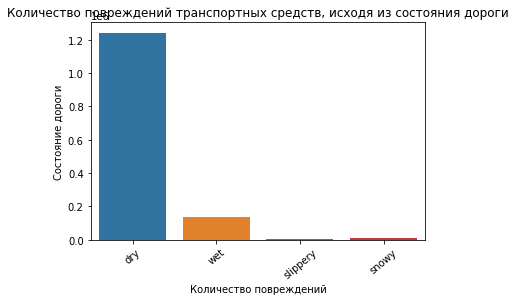

In [11]:
sns.barplot(data = damage_collisions, x='road_surface', y='count_collision_damage')
plt.title('Количество повреждений транспортных средств, исходя из состояния дороги')
plt.xticks(rotation=40)
plt.xlabel('Количество повреждений')
plt.ylabel('Состояние дороги')
plt.show()

**ВЫВОД:**

Чаще всего ДТП происходят когда дорогая сухая (1242026 случаев),но так же можно увидеть что мокрая дорога (136236 случаев), может повлиять на вероятность возникновения ДТП. Как ни странно, на заснеженной дороге меньше всего аварий (7261 случаев). Скорее всего это может быть связано с тем, что водители в зимний период времни более осторожны.

**Найдём самые частые причины ДТП**

In [12]:
 query = '''
select distinct primary_collision_factor,
       count(primary_collision_factor) count_collision_factor
from collisions
where primary_collision_factor != 'unknown' 
group by primary_collision_factor
order by count_collision_factor desc
'''
collisions_reasons = pd.read_sql_query(query, con=engine)
collisions_reasons

,primary_collision_factor,count_collision_factor
0,vehicle code violation,1316453
1,other than driver,29780
2,other improper driving,8470
3,fell asleep,117


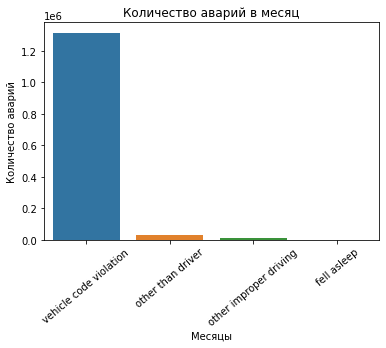

In [13]:
sns.barplot(data = collisions_reasons, x='primary_collision_factor', y='count_collision_factor')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

**ВЫВОД** 

Чаще всего ДТП происходят по причине нарушения ПДД (1316453 случаев), меньше всего по причине того,  что водитель уснул (117 случаев).

**Проверим автомобили какого возраста чаще всего попадают в ДТП**

In [14]:
 query = '''
select count(collision_damage) as count_collision_damage,
       VEHICLE_AGE
from collisions as c
join Vehicles as v on c.case_id=v.case_id
group by VEHICLE_AGE
order by count_collision_damage desc
'''
VEHICLE_AGE_collision_damage = pd.read_sql_query(query, con=engine)
VEHICLE_AGE_collision_damage

,count_collision_damage,vehicle_age
0,178550,3.0
1,125472,4.0
2,106530,2.0
3,105035,5.0
4,84362,6.0
5,84282,7.0
6,77070,8.0
7,58255,9.0
8,41307,1.0
9,40262,0.0


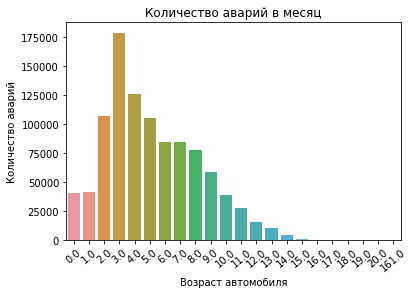

In [15]:
sns.barplot(data = VEHICLE_AGE_collision_damage, x='vehicle_age', y='count_collision_damage')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Возраст автомобиля')
plt.ylabel('Количество аварий')
plt.show()

**ВЫВОД** 

Чаще всего ДТП происходят с автомобилями трёх лет, меньше всего с автомобилями 14 лет. 

**Проверим состояние участника: физическое или с учётом принятых лекарствав и количество дтп**

In [16]:
query = '''
select count(collision_damage) as count_collision_damage,
       PARTY_DRUG_PHYSICAL
from collisions as c
join Parties as p on c.case_id=p.case_id
group by PARTY_DRUG_PHYSICAL
order by count_collision_damage desc
'''
PARTY_DRUG_PHYSICAL_collision_damage = pd.read_sql_query(query, con=engine)
PARTY_DRUG_PHYSICAL_collision_damage

,count_collision_damage,party_drug_physical
0,2320120,None
1,232901,G
2,169343,not applicable
3,13215,under drug influence
4,12641,sleepy/fatigued
5,4188,impairment - physical


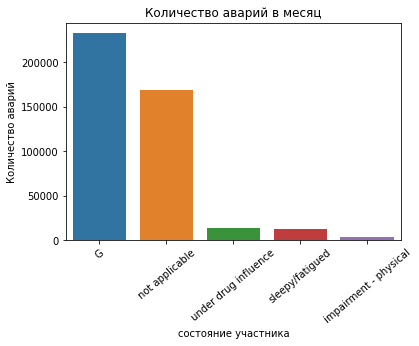

In [17]:
sns.barplot(data = PARTY_DRUG_PHYSICAL_collision_damage, x='party_drug_physical', y='count_collision_damage')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('состояние участника')
plt.ylabel('Количество аварий')
plt.show()

**ВЫВОД** 

Чаще всего сосотояние неизвестно или не оценивается.

**Аналитические задачи для коллег:**

- Проведите анализ серьёзности повреждений транспортного средства, исходя трезвости участника;
- Найдите самые частые причины ДТП.
- Проведите анализ серьёзности повреждений транспортного средства и наличие телефона в автомобиле (возможности разговаривать по громкой связи).
- Проведите анализ серьёзности повреждений транспортного средства в зависимости от типа кузова автомобиля.
- Проведите анализ серьёзности повреждений транспортного средства исходя из времени происшествия
- Проверить зависимоть дтп от освещения
- Проверить зависимоть дтп от типа дороги
- Проведите анализ серьёзности повреждений транспортного средства, исходя из категории нарушения	

## Создайте модель для оценки водительского риска

**Подготовьте набор данных на основе первичного предположения заказчика:**
 
- Выберите тип виновника — только машина (car). 
- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмите данные только за 2012 год.

In [18]:
query = '''
with 
  p as(
        select distinct case_id,
               at_fault,
               party_type, 
               party_sobriety,
               party_drug_physical,
               cellphone_in_use
        from parties),
  c as (
        select distinct case_id,
               weather_1,
               road_surface,
               lighting,
               road_condition_1,
               collision_date,
               collision_damage,
               intersection,
               control_device
        from collisions),
  v as (
        select distinct case_id,
               vehicle_age
        from vehicles),
  c_i as (
          select distinct case_id
          from case_ids)
select p.party_type,
       p.at_fault,
       p.party_sobriety,
       p.party_drug_physical,
       c.road_surface,
       c.lighting,
       c.road_condition_1,
       v.vehicle_age,
       c.intersection,
       p.cellphone_in_use,
       c.control_device,
       c.weather_1
from c_i
join p on c_i.case_id = p.case_id
join c on c_i.case_id = c.case_id
join v on c_i.case_id = v.case_id
where party_type = 'car'
  and collision_date between '2012-01-01' and '2013-01-01'
  and collision_damage != 'scratch'
'''
df = pd.read_sql_query(query, con=engine)

In [19]:
df.head()

,party_type,at_fault,party_sobriety,party_drug_physical,road_surface,lighting,road_condition_1,vehicle_age,intersection,cellphone_in_use,control_device,weather_1
0,car,0,had not been drinking,None,dry,daylight,other,2.0,1.0,0.0,none,cloudy
1,car,1,had not been drinking,None,dry,daylight,other,2.0,1.0,0.0,none,cloudy
2,car,0,had not been drinking,None,dry,daylight,normal,5.0,1.0,0.0,none,clear
3,car,1,had not been drinking,None,dry,daylight,normal,5.0,1.0,0.0,none,clear
4,car,0,had not been drinking,None,dry,daylight,normal,1.0,1.0,0.0,functioning,clear


**Были выбраны:**


- Тип виновника — только машина (car).
- 'at_fault' - Виновность участника (Таблица parties)
- 'party_sobriety' - Уровень трезвости виновника (точно может влиять) (Таблица parties)
- 'party_drug_physical' - Состояние участника: физическое или с учётом принятых лекарств. Таблица parties
- 'cellphone_in_use' - Возможность говорить по громкой связи в машине или нет. Таблица parties
 
 
 
 
 
- 'lighting' - Освещение. Таблица collisions    
- 'road_surface' - Состояние дороги. Таблица collisions   
- 'road_condition_1' - Дорожное состояние. Таблица collisions
- 'intersection' - Является ли перекрестком. Таблица collisions
- 'control_device' - Устройство управления. Таблица collisions
- 'weather_1' - Погода. Таблица collisions



- 'vehicle_age' - Возраст автомобиля (в годах) Таблица Vehicles 



In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101523 entries, 0 to 101522
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   party_type           101523 non-null  object 
 1   at_fault             101523 non-null  int64  
 2   party_sobriety       99951 non-null   object 
 3   party_drug_physical  8438 non-null    object 
 4   road_surface         100910 non-null  object 
 5   lighting             101245 non-null  object 
 6   road_condition_1     101073 non-null  object 
 7   vehicle_age          98622 non-null   float64
 8   intersection         101186 non-null  float64
 9   cellphone_in_use     91676 non-null   float64
 10  control_device       101124 non-null  object 
 11  weather_1            101215 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 9.3+ MB


In [21]:
df.isna().mean()

party_type             0.000000
at_fault               0.000000
party_sobriety         0.015484
party_drug_physical    0.916886
road_surface           0.006038
lighting               0.002738
road_condition_1       0.004432
vehicle_age            0.028575
intersection           0.003319
cellphone_in_use       0.096993
control_device         0.003930
weather_1              0.003034
dtype: float64

Столбец party_drug_physical мог бы быть полезен, но в нем отсутствует более 90% данных, поэтому удалим его:

In [22]:
df.drop('party_drug_physical', axis=1, inplace= True)

In [23]:
df.head()

,party_type,at_fault,party_sobriety,road_surface,lighting,road_condition_1,vehicle_age,intersection,cellphone_in_use,control_device,weather_1
0,car,0,had not been drinking,dry,daylight,other,2.0,1.0,0.0,none,cloudy
1,car,1,had not been drinking,dry,daylight,other,2.0,1.0,0.0,none,cloudy
2,car,0,had not been drinking,dry,daylight,normal,5.0,1.0,0.0,none,clear
3,car,1,had not been drinking,dry,daylight,normal,5.0,1.0,0.0,none,clear
4,car,0,had not been drinking,dry,daylight,normal,1.0,1.0,0.0,functioning,clear


В категориальных значениях есть тоже небольшой процент пропусков, удалим их.

In [24]:
df = df.dropna(subset = ['control_device','party_sobriety','weather_1','road_surface','lighting','road_condition_1'])

In [25]:
df=df.fillna(df[{'vehicle_age','cellphone_in_use','intersection'}].median())

In [26]:
df.isna().mean()

party_type          0.0
at_fault            0.0
party_sobriety      0.0
road_surface        0.0
lighting            0.0
road_condition_1    0.0
vehicle_age         0.0
intersection        0.0
cellphone_in_use    0.0
control_device      0.0
weather_1           0.0
dtype: float64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98385 entries, 0 to 101522
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   party_type        98385 non-null  object 
 1   at_fault          98385 non-null  int64  
 2   party_sobriety    98385 non-null  object 
 3   road_surface      98385 non-null  object 
 4   lighting          98385 non-null  object 
 5   road_condition_1  98385 non-null  object 
 6   vehicle_age       98385 non-null  float64
 7   intersection      98385 non-null  float64
 8   cellphone_in_use  98385 non-null  float64
 9   control_device    98385 non-null  object 
 10  weather_1         98385 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 9.0+ MB


Изменим тип данных на 'int'

In [28]:
columns = ['vehicle_age','intersection','cellphone_in_use']

In [29]:
for i in columns:
    df[i] = df[i].astype(int)

In [30]:
df.dtypes

party_type          object
at_fault             int64
party_sobriety      object
road_surface        object
lighting            object
road_condition_1    object
vehicle_age          int64
intersection         int64
cellphone_in_use     int64
control_device      object
weather_1           object
dtype: object

**Нормализация входных данных**

In [31]:
df.columns

Index(['party_type', 'at_fault', 'party_sobriety', 'road_surface', 'lighting',
       'road_condition_1', 'vehicle_age', 'intersection', 'cellphone_in_use',
       'control_device', 'weather_1'],
      dtype='object')

In [32]:
# разделение на 2 выборки (обучающая и валидационная)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=12345)

# размер таблицы
print(df.shape)
print('Кол-во строк в обучающей выборке:', df_train.shape[0])
print('Кол-во строк в тестовой выборке:', df_test.shape[0])

target=['at_fault']
numerics = ['vehicle_age','intersection','cellphone_in_use']
categories = ['party_sobriety','road_surface','road_condition_1', 'lighting','party_type','control_device', 'weather_1']

(98385, 11)
Кол-во строк в обучающей выборке: 78708
Кол-во строк в тестовой выборке: 19677


In [33]:
# OneHotEncoder обучающая выборка
features_train = df_train.drop(['at_fault'], axis=1)
target_train = df_train['at_fault']

onehot_encoder = OneHotEncoder(sparse=False, drop='first')

result_train = onehot_encoder.fit_transform(features_train[categories])
result_train = pd.DataFrame(result_train, columns=onehot_encoder.get_feature_names(categories),\
                                                                        index=features_train.index)
features_train = result_train.join(features_train[numerics])
features_train.head()

,"party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_flooded,road_condition_1_holes,...,control_device_obscured,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,vehicle_age,intersection,cellphone_in_use
58333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0,0
86939,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0
88725,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,0
24594,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0
24267,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11,0,0


In [34]:
# тестовая
features_test = df_test.drop(['at_fault'], axis=1)
target_test = df_test['at_fault']

result_test = onehot_encoder.transform(features_test[categories])
result_test = pd.DataFrame(result_test, columns=onehot_encoder.get_feature_names(categories),\
                                                                        index=features_test.index)
features_test = result_test.join(features_test[numerics])
features_test.head()

,"party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_flooded,road_condition_1_holes,...,control_device_obscured,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,vehicle_age,intersection,cellphone_in_use
41776,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,1,0
31706,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0
7283,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,0
77879,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0
53939,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,1,0


In [35]:
scaler = StandardScaler()
scaler.fit(features_train[numerics])
features_train[numerics] = scaler.transform(features_train[numerics])
features_test[numerics] = scaler.transform(features_test[numerics])

In [36]:
features_train[numerics]

,vehicle_age,intersection,cellphone_in_use
58333,0.958587,-0.560857,-0.139857
86939,-0.577916,-0.560857,-0.139857
88725,-0.270616,-0.560857,-0.139857
24594,-0.885217,-0.560857,-0.139857
24267,1.880488,-0.560857,-0.139857
...,...,...,...
4222,1.880488,-0.560857,-0.139857
88132,0.651286,-0.560857,-0.139857
2256,-0.577916,-0.560857,-0.139857
79712,-0.577916,1.782986,-0.139857


In [37]:
features_train

,"party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_flooded,road_condition_1_holes,...,control_device_obscured,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,vehicle_age,intersection,cellphone_in_use
58333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.958587,-0.560857,-0.139857
86939,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.577916,-0.560857,-0.139857
88725,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.270616,-0.560857,-0.139857
24594,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.885217,-0.560857,-0.139857
24267,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.880488,-0.560857,-0.139857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.880488,-0.560857,-0.139857
88132,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651286,-0.560857,-0.139857
2256,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.577916,-0.560857,-0.139857
79712,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.577916,1.782986,-0.139857


ВЫВОД:
- Подготовили набор данных на основе первичного предположения заказчика.
- Выберите тип виновника — только машина (car). 
- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмите данные только за 2012 год.

**В датасетах:**
- пропуски обнаружены в столбце party_drug_physical, в нем отсутствовало более 90% данных, поэтому мы его удалили.
- В категориальных значениях есть тоже небольшой процент пропусков, удалили их и заменили на медианные значения.
- заменили типы данных в колонках 'vehicle_age','intersection','cellphone_in_use' на int
- разделили датасет на 2 выборки (обучающая и валидационная)
- Нормализовали входные данные

## Проведите анализ важности факторов ДТП

Для нас важно чтобы наша модель предсказывала виновность участника, важна метрика Recall (is_canceled = 1, predictions = 0) и (is_canceled = 1, predictions = 1):

**Будем использовать recall и roc_auc, так как на нее не влияет дисбаланс классов.**

In [38]:
# Попробуем подобрать параметры для 
# Логистическая регрессия
par_grid_logist = {
                   'intercept_scaling': [0.5, 1.0, 1.5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.5, 1, 1.5]
                   }
model_lg = LogisticRegression(solver='liblinear',random_state=12345)

grid_search_LR = GridSearchCV(model_lg, par_grid_logist, cv=5,
                           scoring=['roc_auc', 'recall'],
                           refit='recall')
grid_search_LR.fit(features_train , target_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=12345,
                                          solver='liblinear'),
             param_grid={'C': [0.5, 1, 1.5], 'class_weight': [None, 'balanced'],
                         'intercept_scaling': [0.5, 1.0, 1.5]},
             refit='recall', scoring=['roc_auc', 'recall'])

In [39]:
grid_search_LR.best_params_

{'C': 0.5, 'class_weight': None, 'intercept_scaling': 0.5}

In [40]:
print(grid_search_LR.best_score_)

0.35048154176424806


In [41]:
grid_search_LR.cv_results_

{'mean_fit_time': array([0.3775197 , 0.41743989, 0.44056554, 0.42265472, 0.37683673,
        0.44030848, 0.43499107, 0.42978358, 0.47567835, 0.40766535,
        0.39431515, 0.4219769 , 0.38293571, 0.42356334, 0.56072774,
        0.47785063, 0.39274206, 0.40014095]),
 'std_fit_time': array([0.07414796, 0.03015833, 0.04902636, 0.01009315, 0.07034288,
        0.01807259, 0.03460135, 0.05627229, 0.05026335, 0.04299509,
        0.03084148, 0.04657491, 0.07003772, 0.0818922 , 0.09411635,
        0.10828014, 0.04434162, 0.0630826 ]),
 'mean_score_time': array([0.06409307, 0.07695327, 0.05743403, 0.0731029 , 0.08171787,
        0.05563693, 0.06221328, 0.07469316, 0.10078874, 0.07048969,
        0.12407002, 0.05590892, 0.09541812, 0.09906282, 0.08705091,
        0.06571126, 0.10454245, 0.07816186]),
 'std_score_time': array([0.00665745, 0.03035266, 0.02680271, 0.01000412, 0.03058767,
        0.01931167, 0.02570479, 0.03464642, 0.02545141, 0.04605575,
        0.03054445, 0.02116688, 0.04541713, 

Теперь перейдем к модели решающего дерева. Переберем гиперпараметры (размер глубины), и выведем на экран при какой глубине результат кросс-валидации дал наивысшую оценку качества модели:

In [42]:
# Модель дерево решений
par_grid_DT = {
                     'criterion': ['gini', 'entropy'],
                     'max_depth': np.arange(1, 10)
              }
model_grid_DT = DecisionTreeClassifier(random_state=12345)

grid_search_DT = GridSearchCV(model_grid_DT, par_grid_DT, cv=5,
                           scoring=['roc_auc', 'recall'],
                           refit='recall'
                          )
grid_search_DT.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             refit='recall', scoring=['roc_auc', 'recall'])

In [43]:
grid_search_DT.best_params_

{'criterion': 'gini', 'max_depth': 8}

In [44]:
print(grid_search_DT.best_score_)

0.48442386242362645


In [45]:
grid_search_DT.cv_results_

{'mean_fit_time': array([0.02195239, 0.03030691, 0.03994613, 0.04857793, 0.0542964 ,
        0.05721641, 0.06334214, 0.06376109, 0.07121611, 0.02201018,
        0.03345933, 0.04132633, 0.04823413, 0.05061703, 0.05431314,
        0.05962839, 0.06312137, 0.06817651]),
 'std_fit_time': array([0.00056358, 0.0019628 , 0.00378418, 0.00272482, 0.0032242 ,
        0.00186261, 0.00196719, 0.00041104, 0.00139327, 0.00044239,
        0.00092122, 0.00090041, 0.00348314, 0.00045403, 0.00106327,
        0.00308551, 0.0017666 , 0.00311516]),
 'mean_score_time': array([0.01367679, 0.01376085, 0.01516113, 0.01602902, 0.01502042,
        0.0149806 , 0.01596808, 0.01489768, 0.01586742, 0.01313281,
        0.01549902, 0.01522284, 0.01486268, 0.0146183 , 0.01450701,
        0.01482158, 0.01507926, 0.01522708]),
 'std_score_time': array([0.00096847, 0.00064094, 0.00116643, 0.00073831, 0.00064617,
        0.00028077, 0.00095239, 0.00027922, 0.00064247, 0.00047422,
        0.00022694, 0.00030493, 0.00046054, 

Теперь перейдем к модели случайного леса. Аналогично работе с предыдущей моделью, в цикле переберем значения гиперпараметра n_estimators, который отвечает за количество деревьев в лесу. Выведем на экран значение n_estimators при котором возможно получить максимальную оценку качества модели, полученную кросс-валидацией:

In [46]:
# Модель случайный лес
par_grid_ensemble = {'n_estimators': [3, 10],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 10)
                    }
model_RF = RandomForestClassifier(random_state=12345)

grid_search_RF = GridSearchCV(model_RF, par_grid_ensemble, cv=5,
                           scoring=['roc_auc', 'recall'],
                           refit='recall'
                          )
grid_search_RF.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': range(5, 10),
                         'n_estimators': [3, 10]},
             refit='recall', scoring=['roc_auc', 'recall'])

In [47]:
grid_search_RF.best_params_

{'criterion': 'entropy', 'min_samples_split': 9, 'n_estimators': 3}

In [48]:
print(grid_search_RF.best_score_)

0.4950880998088807


In [49]:
grid_search_RF.cv_results_

{'mean_fit_time': array([0.09454517, 0.30620785, 0.09483285, 0.28368907, 0.096947  ,
        0.28970942, 0.09138956, 0.27524242, 0.09379506, 0.30018392,
        0.09743714, 0.29553313, 0.10056705, 0.30162578, 0.09732056,
        0.29493513, 0.10015545, 0.30425076, 0.1035563 , 0.2841785 ]),
 'std_fit_time': array([0.00345924, 0.02325423, 0.00352502, 0.00729962, 0.00482734,
        0.00309805, 0.0030812 , 0.00375713, 0.00391977, 0.02399867,
        0.0031892 , 0.00948126, 0.00132335, 0.0088029 , 0.0041229 ,
        0.00192916, 0.00311808, 0.01956865, 0.01052816, 0.00900938]),
 'mean_score_time': array([0.02967353, 0.06651101, 0.03000264, 0.06382494, 0.0298831 ,
        0.06399155, 0.02897596, 0.06329703, 0.0289773 , 0.0653213 ,
        0.0291697 , 0.0648169 , 0.03064475, 0.06485438, 0.03012795,
        0.06460609, 0.02982588, 0.0684607 , 0.03023901, 0.06301956]),
 'std_score_time': array([0.0009011 , 0.00234083, 0.00139396, 0.00046048, 0.00114176,
        0.00041366, 0.00031573, 0.000698

In [50]:
predictive_model_scores = pd.DataFrame(data=[('LogisticRegression',grid_search_LR.best_score_), 
                                             ('DecisionTreeClassifier', grid_search_DT.best_score_),
                                            ('RandomForestClassifier', grid_search_RF.best_score_)], 
                                       columns=['model', 'training_score'])
predictive_model_scores

,model,training_score
0,LogisticRegression,0.350482
1,DecisionTreeClassifier,0.484424
2,RandomForestClassifier,0.495088


**ВЫВОД:**

Таким образом лучшая модель Логистическая регрессия, проверим её на тестовой выборке.


### Проверьте лучшую модель в работе

In [51]:
grid_search_LR.fit(features_train, target_train)
predicted = grid_search_LR.predict(features_test)

roc_auc_test = roc_auc_score(target_test, predicted)
recall = recall_score(target_test, predicted)

print("ROC_auc")
print("Test set:", roc_auc_test)
print("Recall:", recall)

ROC_auc
Test set: 0.5848707229079511
Recall: 0.3346708703544473


**Confusion Matrix**

Создаём матрицу ошибок для обученной модели:

In [52]:
cm = confusion_matrix(target_test, predicted)

In [53]:
cm_df = pd.DataFrame(cm, index=['Actually Not At Fault', 'Actually At Fault'],
                 columns=['Predicted Not At Fault', 'Predicted At Fault'])

**Визуализируем:**

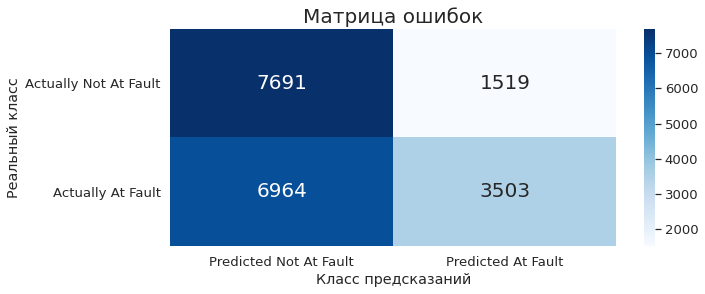

In [54]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df.columns, yticklabels=cm_df.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

In [55]:
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
total = cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированная вина: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие вины: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая вина, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие вины, которой так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')



Всего предсказаний: 19677
Правильно классифицированные: 57.0%
Правильно классифицированная вина: 52.0%
Правильно классифицированое отсутствие вины: 70.0%
Прогнозируемая вина, соответствующая действительности: 84.0%
Прогнозируемое отсутствие вины, которой так же на самом деле нет: 33.0%


In [56]:
#КОД РЕВЬЮЕРА

!pip install eli5
import eli5

eli5.show_weights(estimator=grid_search_LR.best_estimator_, feature_names=list(features_test.columns), top=(20, 12))

Weight?,Feature
+1.541,"party_sobriety_had been drinking, under influence"
+1.102,<BIAS>
+0.670,road_surface_snowy
+0.268,road_condition_1_loose material
+0.264,weather_1_other
+0.249,road_surface_wet
+0.179,road_condition_1_flooded
+0.151,road_condition_1_holes
+0.136,road_condition_1_obstruction
+0.125,road_condition_1_other


Данная модель больше всего обращает внимание на трезвость участника, а именно на показатель: "Был пьян, под влиянием"


Для графического анализа будем использовать столбчатую диаграмму. В ней отразим зависимость числа ДТП от уровня трезвости.

In [57]:
query = '''
select distinct party_sobriety,
       count(case_id) count_party_sobriety
from parties
where party_sobriety != 'had not been drinking'
   and party_sobriety != 'not applicable'
group by party_sobriety
order by count_party_sobriety desc
'''
party_sobriety = pd.read_sql_query(query, con=engine)
party_sobriety

,party_sobriety,count_party_sobriety
0,impairment unknown,232901
1,"had been drinking, under influence",112413
2,"had been drinking, impairment unknown",21419
3,"had been drinking, not under influence",17650


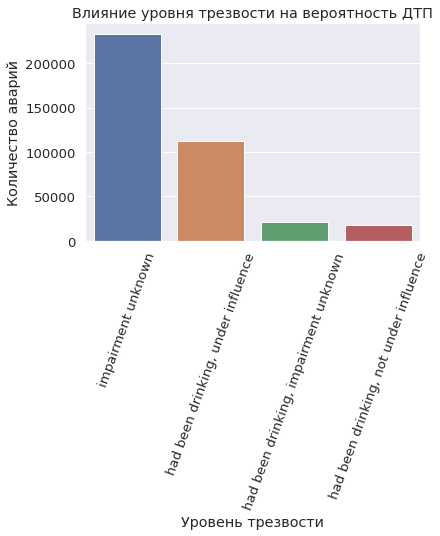

In [58]:
import seaborn as sns
sns.barplot(data = party_sobriety, x='party_sobriety', y='count_party_sobriety')
plt.title('Влияние уровня трезвости на вероятность ДТП')
plt.xticks(rotation=70)
plt.xlabel('Уровень трезвости')
plt.ylabel('Количество аварий')
plt.show()

**ВЫВОД:**

- Выявили, что самый важный фактор ДТП — уровень трезвости виновника party_sobriety. 

- Из таблицы исходных данных известно: есть несколько уровней трезвости. Данная модель больше всего обращает внимание на трезвость участника, а именно на показатель: "Был пьян, под влиянием"

- Предложение оборудовать автомобиль анализатором алкогольного опьянения и однократными экспресс-анализами образца биологической жидкости (слюны) на содержание наркотических веществ. 

- Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что тесты проходит именно водитель, добавить камеру, направленную на водительское место. 

## Выводы

**Таким образом лучшая модель Логистическая регрессия, проверив её на тестовой выборке, получили:**

- Всего предсказаний: 19677
- Правильно классифицированные: 57.0%
- Правильно классифицированная вина: 52.0%
- Правильно классифицированое отсутствие вины: 70.0%
- Прогнозируемая вина, соответствующая действительности: 84.0%
- Прогнозируемое отсутствие вины, которой так же на самом деле нет: 33.0%


- Данная модель больше всего обращает внимание на трезвость участника, а именно на показатель: "Был пьян, под влиянием"

- Так как самый важный фактор ДТП —  показатель: "Был пьян, под влиянием", то можно:

* оборудовать автомобиль анализатором алкогольного опьянения и однократными экспресс-анализами образца биологической жидкости (слюны) на содержание наркотических веществ.

* измерение состояния при посадке сделать обязательным условием допуска за руль, без этого машина не заведется

* чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место

* чтобы убедиться, что в трубку дышит именно водитель, добавить отпечаток пальца или face id на водительском месте

**Возможно создание адекватной системы оценка риска при выдаче авто, однако создание такой системы несёт существенные траты. Чтобы улучшить модель, необходимо соотнести траты на оборудование автомобилей и процент уменьшения ДТП. Предложение - оборудовать несколько автомобилей и проверить результат, а уже потом проводить массовое внедрение.**
